In [1]:
from sys import path

path.append("../")

from src.data.smile import SmileData
from numpy import ndarray

from sklearn.feature_selection import mutual_info_classif
from pandas import DataFrame
import ipywidgets as widgets

# from src.utils import slice_user_over_experiment_time
# from src.utils.correlation import calculate_correlation_coefficients
# from scipy.stats import pearsonr, spearmanr, kendalltau
# from time import time
# from tqdm.notebook import tqdm
from seaborn import barplot, set_theme, color_palette
from matplotlib.pyplot import (
    figure,
    savefig,
    show,
    title,
    xlabel,
    legend,
    tight_layout,
    xticks,
)

# from numpy import array, asarray, ndarray, mean
# from copy import deepcopy

from pandarallel import pandarallel

pandarallel.initialize()

set_theme(style="whitegrid")

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
ecg_features_names: list[str] = [
    "HR mean",
    "HR HRV std R-R",
    "HR RMSE R-R diff",
    "HR low freq",
    "HR high freq",
    "HR ratio low/high freq",
    "HR ratio very low/low freq",
    "HR cycle",
]

gsr_features_names: list[str] = [
    "GSR avg",
    "GSR signal power phasic",
    "GSR response rate",
    "GSR second difference",
    "GSR #responses",
    "GSR magnitude",
    "GSR duration",
    "GSR area",]

st_features_names: list[str] = [
    "ST avg",
    "ST std",
    "ST slope fitted",
    "ST median"]

features: list[tuple[str, str]] = [
            ("hand_crafted_features", "ECG_features"),
            ("hand_crafted_features", "GSR_features"),
            ("hand_crafted_features", "ST_features"),
            ("deep_features", "ECG_features_C"),
            ("deep_features", "ECG_features_T"),
        ]

# Introduction

In this notebook, feature selection analysis is performed. 

Since many feature selection methods are available in literature, a decision has to be made regarding which route to take. 
Since the objective of the current work is not only that of achieving the "highest" possible performance, but also to show some very explainable methods, the same principle shall be applied here.

As such, the feature selection strategy is based on the use of the **Mutual Information** value, which, probability theory, is a measure which quantifies the mutual dependance between two variables. The great benefit of this is that it allows to quantify the importance of each feature in the dataset with a single value, which at the same time is very different from the correlation coefficient, used in the correlation analysis (see `correlation.ipynb`).

However, in order to perform feature selection, there is a requirement for where to set the number of features to select. This is so important that the can determine the performance of the successive classifiers. 
In order to determine this, a ranking based on the MI shall be used: since this decision is very data-dependant, and no similar work is present in literature, it shall be the road taken.

# Mutual Information Ranking

In [3]:
path_to_data: str = "../data.nosync/dataset_smile_challenge_unravelled_train_cut10_stadd.npy"
data = SmileData(path_to_data=path_to_data, test=False, unravelled=True, st_feat=True)
# data.separate_skin_temperature()

hand_crafted_data: ndarray = data.get_handcrafted_features(masking=False, joined=False)
# deep_data: ndarray = data.get_deep_features(masking=False, joined=True)
labels: ndarray = data.get_labels()

In [4]:
hand_crafted_data.keys()

dict_keys(['ECG_features', 'GSR_features', 'ST_features'])

In [5]:
def get_sensor_features(sensor: str) -> list[str]:
    if sensor == "ECG_features":
        return ecg_features_names
    elif sensor == "GSR_features":
        return gsr_features_names
    elif sensor == "ST_features":
        return st_features_names


results: list[DataFrame] = []
for sensor in hand_crafted_data.keys():
    results.append(
        DataFrame(
            {
                feat_name: feat_mi_val
                for feat_name, feat_mi_val in zip(
                    get_sensor_features(sensor),
                    mutual_info_classif(
                        X=hand_crafted_data[sensor],
                        y=labels,
                        copy=True,
                        n_neighbors=3,
                        random_state=42,
                    ),
                )
            },
            index=[sensor],
        )
    )


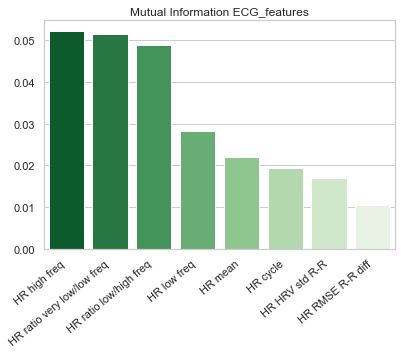

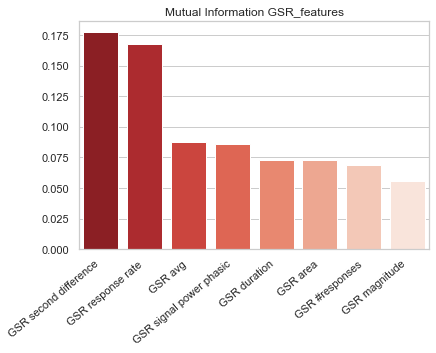

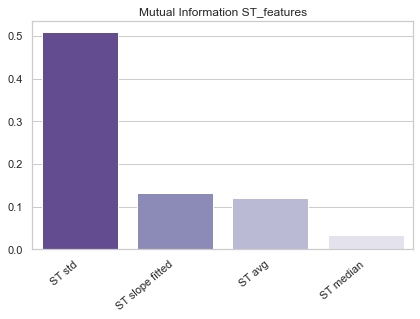

In [9]:
pals = [
    reversed(color_palette(palette_name, len(result.columns)))
    for palette_name, result in zip(["Greens", "Reds", "Purples"], results)
]
for el, pal in zip(results, pals):
    barplot(data=el.T.sort_values(by=el.index[0], ascending=False).T, palette=pal)
    title(f"Mutual Information {el.index[0]}")
    tight_layout()
    xticks(rotation=40, ha="right")
    savefig(f"../visualizations/mi_{el.index[0]}.pdf")
    show()


From this graphical representations, a few key points can be observed, for the 3 classes of sensors.

### Together

In [7]:
hand_crafted_data: ndarray = data.get_handcrafted_features(masking=False, joined=True)

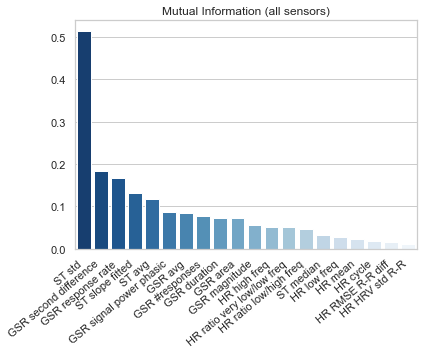

In [10]:
res = mutual_info_classif(
    X=hand_crafted_data,
    y=labels,
    copy=True,
    n_neighbors=3,
    random_state=42,
)
res = DataFrame(
    res,
    index=ecg_features_names + gsr_features_names + st_features_names,
    columns=["MI"],
)

barplot(
    data=res.sort_values(by="MI", ascending=False).T,
    palette=reversed(color_palette("Blues", len(res.index))),
)
title(f"Mutual Information (all sensors)")
tight_layout()
xticks(rotation=40, ha="right")
savefig(f"../visualizations/mi_all.pdf")
show()


The Mutual Information evaluations show a slightly different story, when taken together, when compared to the correlation analysis. Indeed, it may appear that heart rate features are less important than gsr features. 

However, for the moment we can ignore this matter, since the 3 sensors shall be trained independenty, and joined at a later time together.

# Feature Selection Percentage

From this barplots above, it is clear which features are to be selected. But justifying this from a graphical point of view is easier said than done, and indeed requires a lot of attention. For this, the usage of a **percentage** might suit best.

In [48]:
path_to_data: str = "../data.nosync/dataset_smile_challenge_unravelled_train_cut10_stadd.npy"
data = SmileData(path_to_data=path_to_data, test=False, unravelled=True, st_feat=True)
# data.separate_skin_temperature()

hand_crafted_data: ndarray = data.get_handcrafted_features(masking=False, joined=False)
# deep_data: ndarray = data.get_deep_features(masking=False, joined=True)
labels: ndarray = data.get_labels()

print(hand_crafted_data.keys())

dict_keys(['ECG_features', 'GSR_features', 'ST_features'])


In [49]:
PERC: int = 30  # percent for the feature selection (top PERC)

In [58]:
from sklearn.feature_selection import SelectFpr, chi2, SelectFdr, SelectPercentile, SelectFwe


def get_sensor_features(sensor: str) -> list[str]:
    if sensor == "ECG_features":
        return ecg_features_names
    elif sensor == "GSR_features":
        return gsr_features_names
    elif sensor == "ST_features":
        return st_features_names


hand_crafted_data_feature_selected: dict[str, ndarray] = {
    sensor: SelectPercentile(
        score_func=mutual_info_classif,
        percentile=PERC
    ).fit_transform(hand_crafted_data[sensor], labels)
    for sensor in hand_crafted_data.keys()
}


In [59]:
hand_crafted_data_feature_selected['GSR_features'].shape

(20700, 3)

Using a percentage of 30%, we end up with:
1. ECG: 3 features
2. GSR: 3 features
3. ST: 1 feature

This is in line, but not perfect, with the results that can be seen from the barplots above.

A more complex feature selection, e.g. based on the difference w/ the best, e.g. no more than 30% different than the best, could be applied. For the moment, though, this is considered something reasonable.